## Updated 20180418

## Yuqiong Li


## 1. Introduction

### Business problem
This notebook illustrates a sample data science case study. 

The business problem at hand is targeted marketing for a Portuguese bank's phone campaign of its term deposits. The bank wants to know which of its customers have higher chance of subscribing to term deposits. It can then tailor its campaign to these customers to optimize advertising cost and improve success rate.


### Machine Learning Set-up

We are going to build a predictive model that, given the following input information, can predict the outcome of customer's subscription results. Input:

- customer's demographical information
- customer's financial information
- customer's past subscription information

The model will output a binary variable, for which 0 indicates non-subscription and 1 indicates subscription.

Parameters of the model will be determined by optimizing a loss function on the training data. Performance of the model will be evaluated on test data which it has not seen before. 

Dataset is acquired from the UCI machine learning repository: https://archive.ics.uci.edu/ml/datasets/bank+marketing



## 2. Exploratory Data Analysis 

The first step is to inspect the data and see if there are interesting patterns in the dataset.

In [6]:
import pandas as pd
import numpy as np

data = pd.read_csv('bank-additional/bank-additional-full.csv',sep=';')
print(data.columns)
print(data.shape)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')
(41188, 21)


There are 20 features and 1 target variable in the dataset, name indicated above. There are 41188 samples in the dataset. Let's see a sample of the data...

In [7]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


The next step is to find out the **base rate** of subscription in the data. i.e. what's the overall percentage of people subscribing to a term deposit? We would also transfrom target, y, from a string to a binary outcome.

In [8]:
data['Y']=(data['y']=='yes').astype(int) # transform y from string to binary, numerical variables
data.drop('y', axis = 1, inplace = True)
pos_percent = (data[data['Y'] == 1]['Y']).sum()/len(data)
print(pos_percent)

0.112654171118


The base rate is around 11%, which is quite high! 

### Social economic contextual variables

The next step is to find out if there are interesting correlations between features. We first inspect with regard to social economic contextual variables, including :

- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric) 
- cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

In [9]:
import seaborn as sns
social_data = data[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m','nr.employed']]
print ('Number of mising value:',social_data.isnull().sum().sum())

number of mising value: 0


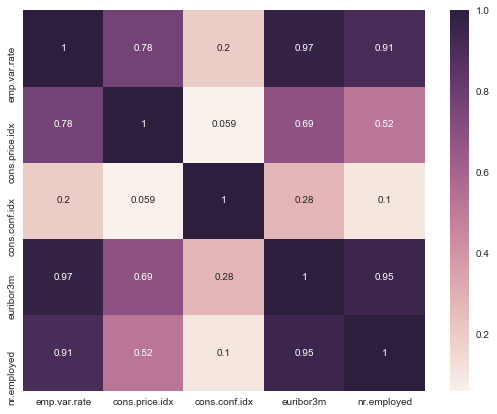

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

social_data_cor = social_data.corr()
f, ax = plt.subplots(figsize=(9,7))

heatmap = sns.heatmap(social_data_cor, annot=True, ax = ax)

figure = heatmap.get_figure()    
figure.savefig('svm_conf.png', dpi=400)

The following data pairs have high correlations:
- emp.var.rate and euribor3m
- emp.var.rate and nr.employed

Next we explore monthly variations of subscription rate. For some reason, Jan and Feb data are missing in this dataset, we thus ignore them...

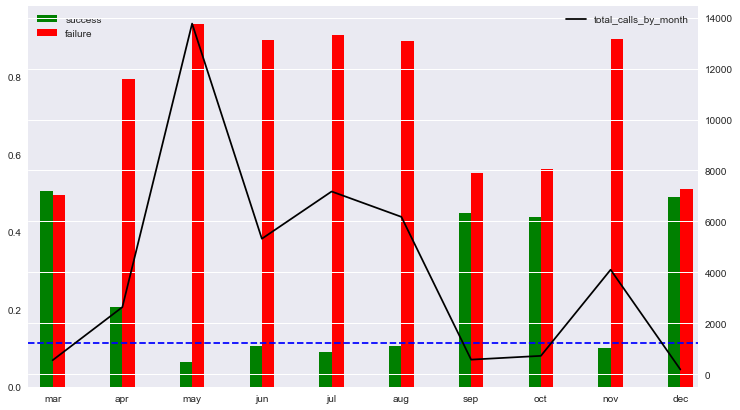

In [14]:
months = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
calls_by_month = dict(data.groupby(['month'])['duration'].count())

sucess = []
failure = []
total_calls = []
for month in months:
    temp = (data[data['month'] == month]['Y'] == 1).sum()/(data['month']== month).sum()
    sucess.append(temp)
    failure.append(1-temp)
    total_calls.append(calls_by_month[month])

month_data = pd.DataFrame({'success': sucess, 'failure': failure, 'total_calls_by_month': total_calls})


month_data[['success','failure']].plot(kind='bar', width = 0.35, figsize=(12, 7), color = ['g','r'])
plt.axhline(y = pos_percent, linestyle='--', color = 'b')

month_data['total_calls_by_month'].plot(secondary_y=True, color = 'black')


ax = plt.gca()
plt.xlim([-0.35, 9.25])
plt.legend()
ax.set_xticklabels(months)

The results show that some months have much higher success rate than other months (e.g. Mar, Sep, Oct, and Dec). We have not figured out why, but it seems that when the total number of calls per month is small, the success rate appears higher. 

Next we check if the number of employees relate to the success rate of calls.

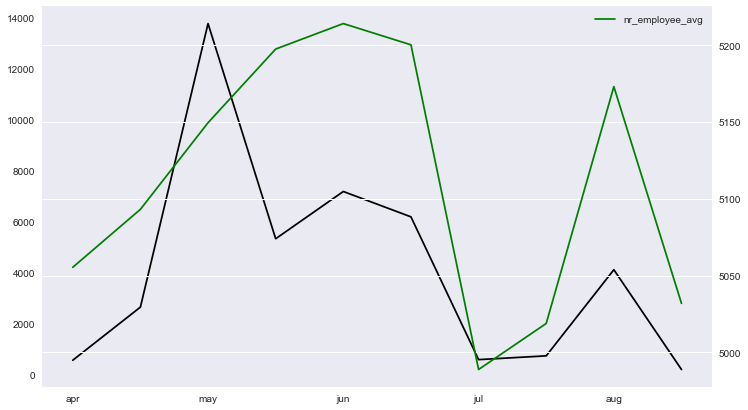

In [18]:
num_employeed = dict(data.groupby('month')['nr.employed'].mean())
num_employeed_list=[]
for month in months:
    num_employeed_list.append(num_employeed[month])

month_data['nr_employee_avg'] = num_employeed_list

month_data['total_calls_by_month'].plot(figsize=(12, 7), color= 'black')
month_data['nr_employee_avg'].plot(secondary_y=True, color = 'green')

ax = plt.gca()
plt.legend()
ax.set_xticklabels(months)

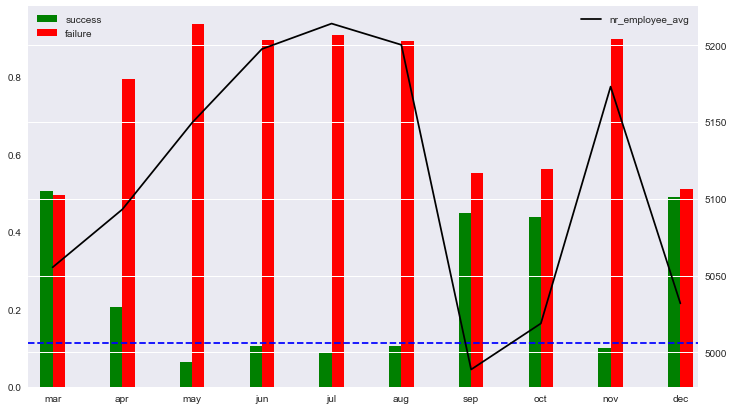

In [19]:
month_data[['success','failure']].plot(kind='bar', width = 0.35, figsize=(12, 7), color = ['g','r'])
plt.axhline(y = pos_percent, linestyle='--', color = 'b')

month_data['nr_employee_avg'].plot(secondary_y=True, color = 'black')
plt.xlim([-0.35, 9.25])
ax = plt.gca()
plt.legend()
ax.set_xticklabels(months)

Total number of employees does seem to relate to success rate of calls. Especially, when the total number of employees is low, the call success rate is high. But why? This is the interesting question. 

Could it be that when the total number of employees is low, which means unemployment rate is high, the bank employees actually works harder to persuade the customers? This can be verified with the variable, "duration of calls" in the dataset...

In [20]:
import warnings
warnings.filterwarnings('ignore')

data['new_duration'] = 0
data['new_duration'][(data['duration'] > 1500)] = '1500+'
data['new_duration'][(data['duration']>1000)&(data['duration']<=1500)] = '1000-1500'
data['new_duration'][(data['duration']>500)&(data['duration']<=1000)] = '500-1000'
data['new_duration'][(data['duration']>319)&(data['duration'] <= 500)] = '320-400'
data['new_duration'][(data['duration']>258)&(data['duration'] <= 319)] = '259-319'
data['new_duration'][(data['duration']>180)&(data['duration'] <= 258)] = '181-258'
data['new_duration'][(data['duration']>102)&(data['duration'] <= 180)] = '103-180'
data['new_duration'][(data['duration']>0)&( data['duration'] <= 102)] = '1-102'
data['new_duration'][(data['duration'] == 0)] = '0'

In [22]:
def draw_var(var_name):
# data to plot
    if var_name == 'month':
        unique_values = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    elif var_name == 'new_duration':
        unique_values = ['0','1-102','103-180', '181-258','259-319','320-400','500-1000','1000-1500','1500+']
    else:
        unique_values = [v for v in data[var_name].value_counts().index]
        unique_values.sort()
    
    n_groups = len(unique_values)
    pos_var_list = []
    neg_var_list = []
    
    for var in unique_values:
        temp_pos = (data[data[var_name]==var]['Y'] == 1).sum()/(data[var_name]==var).sum()
        pos_var_list.append(temp_pos)
        neg_var_list.append(1-temp_pos)
        
     # create plot
    fig, ax = plt.subplots(figsize=(10,6))
    index = np.arange(n_groups)
    bar_width = 0.3
    opacity = 0.8
    rects1 = plt.bar(index, pos_var_list, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Positives')
    rects2 = plt.bar(index + bar_width, neg_var_list, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Negatives')

    plt.ylabel('Results')
    if var_name != 'age':
        plt.xticks(index + bar_width, unique_values)
    else:
        plt.xticks(index + bar_width, unique_values, rotation = 90)
        
    plt.axhline(y=pos_percent, linestyle='--')
    plt.legend()
    plt.tight_layout()

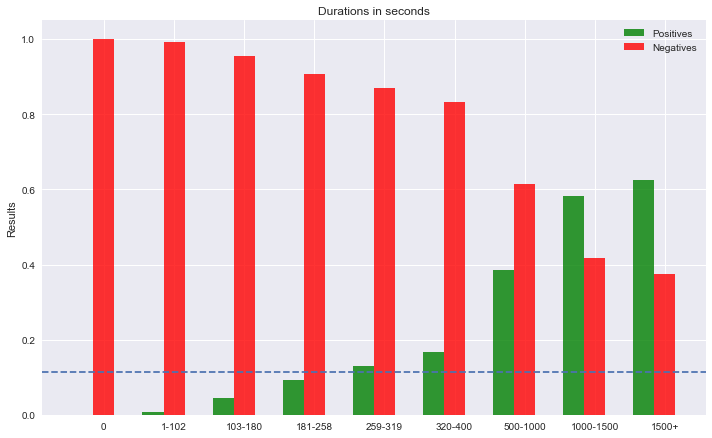

In [23]:
draw_var('new_duration')
plt.title('Durations in seconds')

True. When the call duration is high, success rate is high. However, this finding has the surviver's bias, i.e. when a customer is uninterested s/he will probably hang up the call immediately! So the success rate is of course low. This variable suffers from the leakage problem in that it is partly is related to the outcome! We might want to drop the duration variable in our final model.

### Call history variable

The following variables relates to the customer's contact history with the bank.

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')



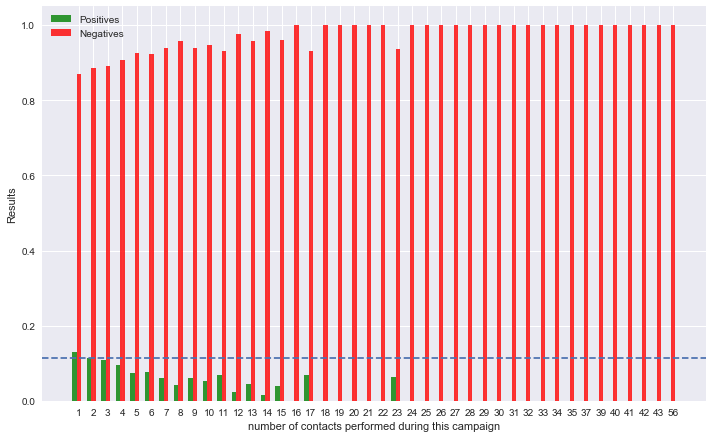

In [26]:
draw_var('campaign')
plt.xlabel('number of contacts performed during this campaign')

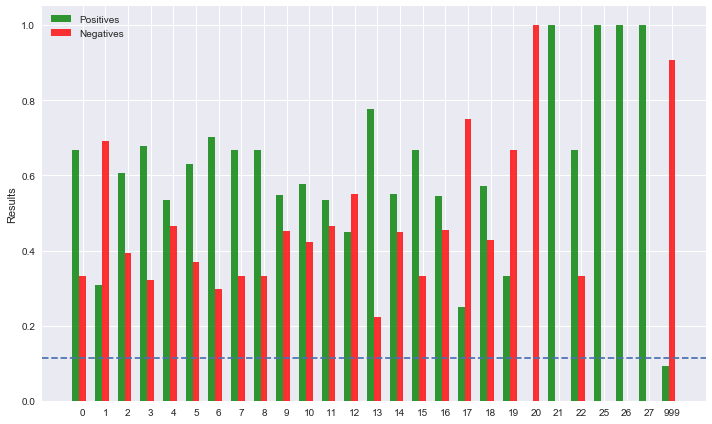

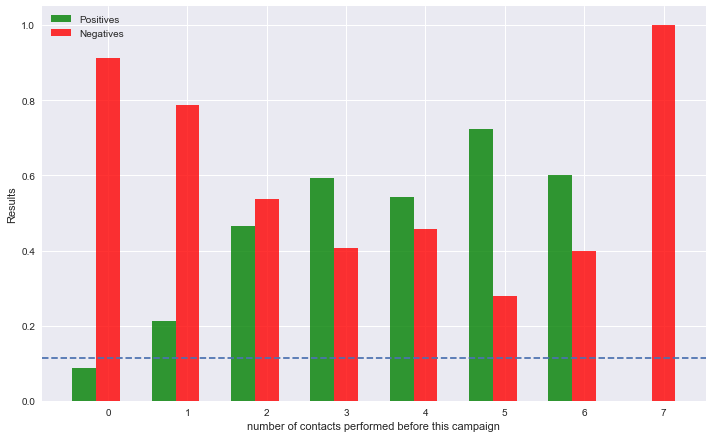

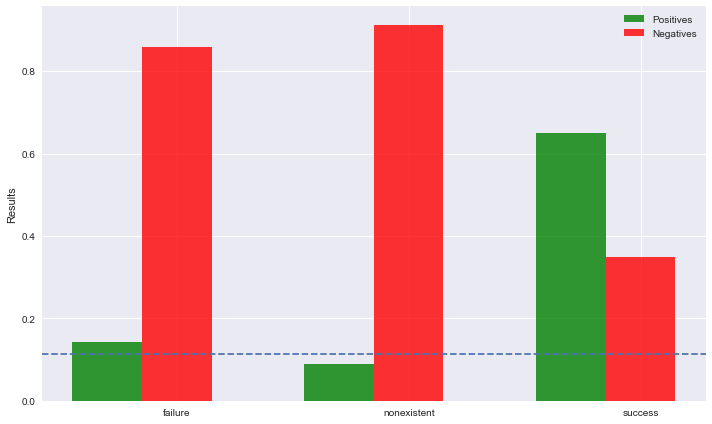

In [27]:
draw_var('pdays')
draw_var('previous')
plt.xlabel('number of contacts performed before this campaign')
draw_var('poutcome')

Here it is for number of campaigns performed before this campaign...

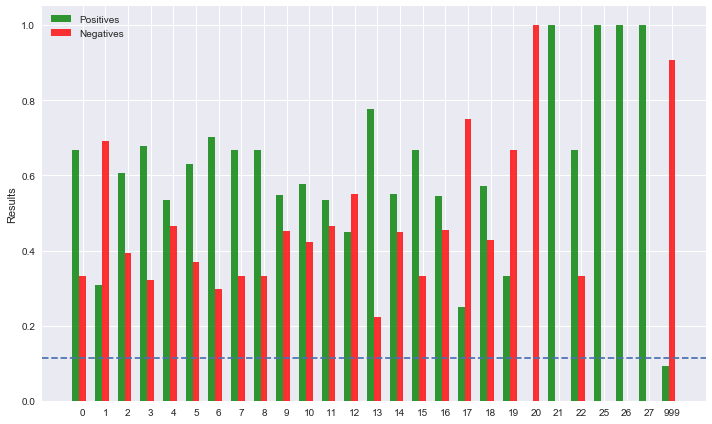

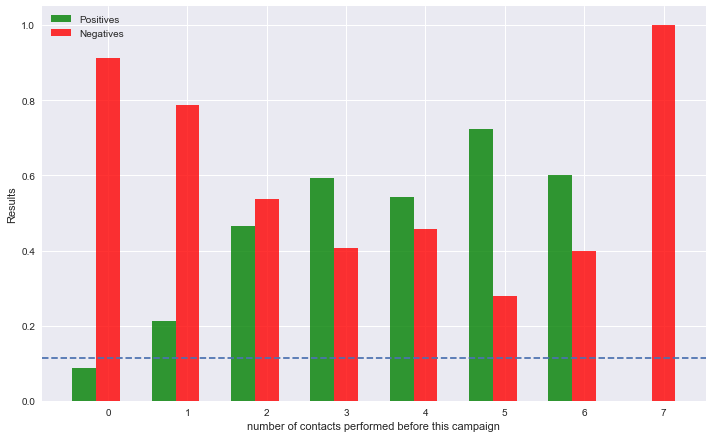

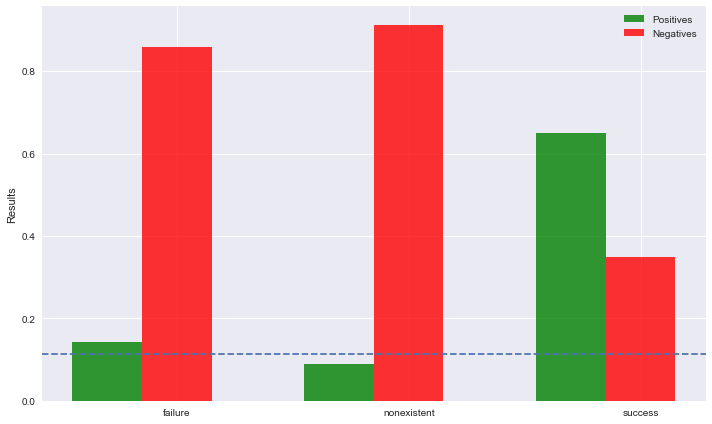

In [28]:
draw_var('pdays')
draw_var('previous')
plt.xlabel('number of contacts performed before this campaign')
draw_var('poutcome')

## 3. Preprocessing: missing  data  and scaling


Next we will try dealing with unknown / missing data. The first step is to see if missing data shows certain patterns, or are missing at random. This will influence how we process the data later.

In [24]:
ind = []
unknown_portion = []
P_y_given_unknown = []
for col in data.columns:
    if 'unknown' in data[col].value_counts().index:
        ind.append(col)
        unknown_portion.append((data[col] == 'unknown').sum()/len(data))
        P_y_given_unknown.append(sum(data['Y'][data[col]=='unknown']==1)/sum(data[col]=='unknown'))

na_info = pd.DataFrame({'unknown_portion':unknown_portion,'P_y_given_unknown':P_y_given_unknown }, index = ind)
na_info

,P_y_given_unknown,unknown_portion
job,0.112121,0.008012
marital,0.150000,0.001942
education,0.145003,0.042027
default,0.051530,0.208726
housing,0.108081,0.024036
loan,0.108081,0.024036


In [25]:
pd.crosstab(data['housing'], data['loan'])

loan,no,unknown,yes
housing,,,
no,16065,0,2557
unknown,0,990,0
yes,17885,0,3691


The variables 'housing' and 'loan' seem to be related in that when one of them is 'unknown', the other is 'unknown' as well. This makes sense as when we do not know if a person has housing or not we will not know the person's loan situation. 

That being said, now we begin dealing with unknown data with the following strategy: 

- For continuous data, change it with average 
- For categorical data, change it to a new category

The result will be there is no more NaNs in the dataset. Check:

In [29]:
# Check number of NaNs
for col in new_df.columns:
    print(col + ' ' + str(new_df.isnull().values.any()))

age False
job False
marital False
education False
default False
housing False
loan False
contact False
month False
day_of_week False
duration False
campaign False
pdays False
previous False
poutcome False
emp.var.rate False
cons.price.idx False
cons.conf.idx False
euribor3m False
nr.employed False
y False


### Preprocessing

First we drop two variables due to 1) data leakage and 2) too many missing values.

In [34]:
# drop new_duration
data.drop('new_duration', axis = 1, inplace = True)

In [35]:
#drop pdays
data.drop('pdays', axis = 1, inplace = True)

In [36]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


Next, we convert categorical variables into dummy variables...

In [37]:
datatype = dict(data.dtypes)

catego_val = []
numerical_val = []
for key, item in datatype.items():
    if item == 'object':
        catego_val.append(key)
    else:
        numerical_val.append(key)

print (len(catego_val), catego_val)

10 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [38]:
dummy_data = pd.get_dummies(data=data, columns = catego_val)

In [39]:
dummy_data.columns

Index(['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'Y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 

In [40]:
dummy_data.drop('housing_unknown', axis = 1, inplace = True)
#since housing_unknown is completely identical with loan_unknown

In [41]:
data[numerical_val].describe()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


Next we scale the data!

In [43]:
from sklearn.preprocessing import StandardScaler

normal_val = ['duration', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m','nr.employed']

scale = StandardScaler()
normalized = scale.fit_transform(data[normal_val])

normalized_data = pd.DataFrame.from_dict(normalized)
normalized_data.columns = normal_val

In [44]:
##update the data with normalized variables
for val in normal_val:
    dummy_data[val] = normalized_data[val]

In [45]:
dummy_data.head()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Y,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,0.010471,1,0,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,0,0,0,1,0,0,0,0,1,0
1,57,-0.421501,1,0,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,0,0,0,1,0,0,0,0,1,0
2,37,-0.124520,1,0,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,0,0,0,1,0,0,0,0,1,0
3,40,-0.413787,1,0,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,0,0,0,1,0,0,0,0,1,0
4,56,0.187888,1,0,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,0,0,0,1,0,0,0,0,1,0


In [46]:
dummy_data_noduration = dummy_data.drop('duration', axis = 1)

In [48]:
dummy_data_noduration_X = dummy_data_noduration.drop('Y', axis = 1)
dummy_data_noduration_Y = dummy_data_noduration['Y']

## 4. Train a model

In [50]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_target, test_target = train_test_split(dummy_data_noduration_X, dummy_data_noduration_Y , test_size=0.2, random_state=42)

In [51]:
train_features.shape

(32950, 60)

In [52]:
train_target.shape

(32950,)

###  Build cross validation set and prepare for GridSearch

In [54]:
from sklearn.cross_validation import KFold
kfolds = KFold(train_features.shape[0], n_folds = 5)

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

SVM_parameters = {'kernel':('sigmoid', 'rbf', 'poly'), 'C':[1, 10, 100]}
lr_parameters = dict(C = [10**i for i in range(-3, 3)],
                  penalty = ['l1', 'l2'])
knn_parameters = {'n_neighbors': [5, 10, 15, 20], 'weights':['uniform', 'distance'], 'leaf_size':[20,30,40]}
nn_parameters = dict(hidden_layer_sizes=[(30,),(50,),(70,),(100,)], activation=['relu', 'tanh', 'logistic'], learning_rate=['constant', 'adaptive'])
decision_parameters = dict(max_depth=[5, 10, 15, 20], min_samples_split=[2,6,12], min_samples_leaf=[1,10,20])

print("done")

done


### Logistic Regression GridSearch

In [ ]:
lr_grid_search = GridSearchCV(linear_model.LogisticRegression(), lr_parameters, cv = kfolds, scoring = 'roc_auc') 
lr_grid_search.fit(train_features, train_target)


#3rd, get the score of the best model and print it
best_1r_1 = lr_grid_search.best_score_
print(best_1r_1)


0.794946335298


### KNN grid search

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_parameters, cv = kfolds, scoring = 'roc_auc') 
knn_grid_search.fit(train_features, train_target)

#3rd, get the score of the best model and print it
best_knn_1 = knn_grid_search.best_score_
print(best_knn_1)

### Neural network grid search

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=43)
nn_grid_search = GridSearchCV(mlp, nn_parameters, cv = kfolds, scoring = 'roc_auc') 
nn_grid_search.fit(train_features, train_target)

#3rd, get the score of the best model and print it
best_nn_1 = nn_grid_search.best_score_
print(best_nn_1)

In [ ]:
nn_grid_search.best_estimator_

### Decision Tree grid search

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), decision_parameters, cv = kfolds, scoring = 'roc_auc') 
dt_grid_search.fit(train_features, train_target)

#3rd, get the score of the best model and print it
best_dt_1 = dt_grid_search.best_score_
print(best_dt_1)

In [ ]:
dt_grid_search.best_estimator_

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# defines a classification tree
def NBClassifier(X_train,y_train,X_test,y_test, auc):
    clf = GaussianNB()
    clf.fit(X_train,y_train)
    if (auc==0):
        cm = confusion_matrix(clf.predict(X_test),y_test)
        return cm # (cm[0][0]+cm[1][1])/float(sum(cm))
    else:
        return roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

In [ ]:
auc = NBClassifier(train_features,train_target,test_features,test_target, 1)
auc

# XGBoost

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# fit model no training data
model = XGBClassifier()
model.fit(train_features, train_target)

# make predictions for test data
xgboost_pred = model.predict(test_features)
predictions = [round(value) for value in xgboost_pred]

# evaluate predictions
accuracy = accuracy_score(test_target, xgboost_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Mean accuracy Score: 0.91
Mean squared error: 0.09
Variance score: 0.09


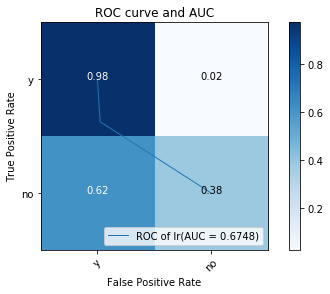

10713 255 871 518
[ 0.90412621  0.89927184  0.89805825  0.90412621  0.90291262  0.89320388
  0.89563107  0.9211165   0.90412621  0.90533981  0.90898058  0.90533981
  0.89441748  0.91626214  0.88592233  0.89684466  0.90048544  0.92718447
  0.89441748  0.8907767   0.90898058  0.91626214  0.92839806  0.93082524
  0.91868932  0.88956311  0.89805825  0.89805825  0.90291262  0.91262136
  0.90898058  0.89199029  0.93203883  0.93325243  0.93082524  0.91747573
  0.86043689  0.85558252  0.9211165   0.93203883  0.92709599  0.91737546
  0.94167679  0.94775213  0.95868773  0.96597813  0.70230863  0.74969623
  0.4026764   0.3406326 ]
Accuracy: 0.88 (+/- 0.22)


In [28]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Create linear regression object
regr = linear_model.LogisticRegression()

# Train the model using the training sets
regr.fit(train_features, train_target)

# Make predictions using the testing set
predict_y = regr.predict(test_features)


# The predict score
print("Mean accuracy Score: %.2f" % regr.score(test_features,test_target))
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(test_target, predict_y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_target, predict_y))
# The coefficients
# print('Coefficients: \n', regr.coef_)


fpr, tpr, thresholds = roc_curve(test_target, predict_y)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1,label="ROC of lr" +"(AUC = %0.4f)" %roc_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve and AUC')
plt.legend(loc="lower right")
plt.show()


tn, fp, fn, tp = confusion_matrix(test_target, predict_y).ravel()
print(tn, fp, fn, tp)
##################################################
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regr, new_df_num.drop(labels = 'y', axis = 1), new_df_num["y"], cv=50)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [49]:
import matplotlib.pyplot as plt

lab='y_buy'

depths=[4,5,10,20]
leaves=np.arange(1,101)

#Run all of the options
run=1
if (run==1):
    #Initialize dictionary of results
    res=dict()
    for d in depths:
        res[d]=list()

    #Now train and get results for each option
    for d in depths:
        for l in leaves:
            res[d].append(testTrees(train_features,train_target,test_features,test_target, d, l, 1))


#Now plot            
fig = plt.figure()
ax=fig.add_subplot(111)
plt.plot(leaves,res[depths[0]],'b-',label='Depth={}'.format(depths[0]))
plt.plot(leaves,res[depths[1]],'r-',label='Depth={}'.format(depths[1]))
plt.plot(leaves,res[depths[2]],'y-',label='Depth={}'.format(depths[2]))
plt.plot(leaves,res[depths[3]],'g-',label='Depth={}'.format(depths[3]))
plt.legend(loc=4)
ax.set_xlabel('Min Leaf Size')
ax.set_ylabel('Test Set AUC')
plt.title('Holdout AUC by Hyperparameters')

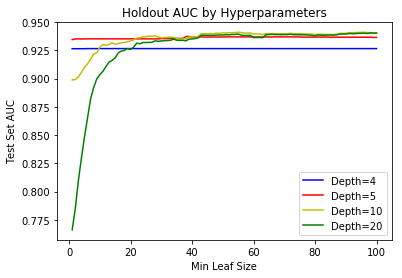

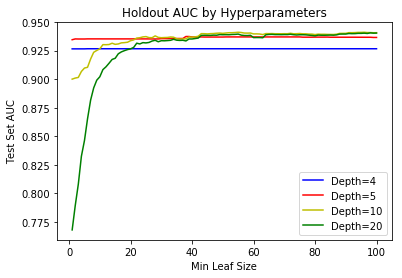

In [46]:
plt.show()

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
# import course_utils as bd
# imp.reload(bd)

In [53]:
# We'll build a RF and compare to a DT
clf_def = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 20)
clf_def = clf_def.fit(train_features, train_target)
# dt_pred = clf_def.predict_proba(test_features)
dt_pred = clf_def.predict(test_features)

rf_def = RandomForestClassifier(criterion='entropy', n_estimators=100)
rf_def = rf_def.fit(train_features, train_target)
# rf_pred = rf_def.predict_proba(test_features)
rf_pred = rf_def.predict(test_features)

In [54]:
# A function to plot AUC, from course Git

def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")

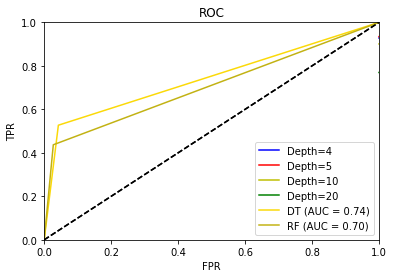

In [55]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

plotAUC(test_target, dt_pred, 'DT')
plotAUC(test_target, rf_pred, 'RF')
plt.show()

# Evaluation

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return cm

Model: regr-------------------------------------
Mean squared error: 0.0909
Variance score: 0.0909
F1 score:0.4846
Precision:0.8967
Normalized confusion matrix
[[ 0.97638722  0.02361278]
 [ 0.62068966  0.37931034]]


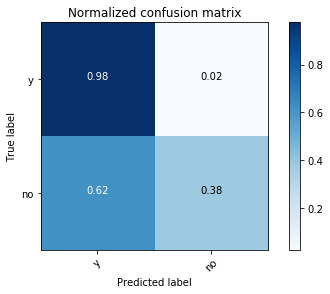

Model: rf_def-------------------------------------
Mean squared error: 0.0262
Variance score: 0.7377
F1 score:0.8772
Precision:0.9732
Normalized confusion matrix
[[ 0.99184634  0.00815366]
 [ 0.16853448  0.83146552]]


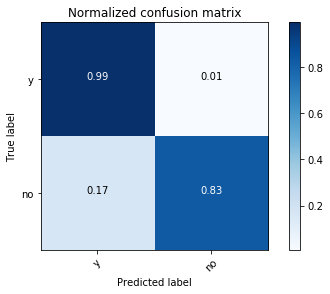

The profit expection for each model is : [90.431825129352802, 96.499289078509889]
done


In [60]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import itertools
import numpy as np
# lr_grid_search, knn_grid_search,nn_grid_search,dt_grid_search
# test set features and labels
test_X = new_df_num.drop(labels = 'y', axis = 1)
test_Y = new_df_num['y']

# models = [lr_grid_search,knn_grid_search,nn_grid_search,dt_grid_search]
# modelsName = ["lr_grid_search","knn_grid_search","nn_grid_search","dt_grid_search"]
models = [regr,rf_def]
modelsName = ["regr","rf_def"]
profit_matrix = [[99,-1],[-10,0]]
profit_list = list()

for m,n in zip(models, modelsName):
    predict_y = m.predict(test_X)
    # The mean squared error
    print("Model: " + str(n) + "-------------------------------------")
    print("Mean squared error: %.4f" % mean_squared_error(test_Y, predict_y))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.4f' % r2_score(test_Y, predict_y))
    # The f1 score
    print("F1 score:%0.4f" % f1_score(test_Y, predict_y))
    # Precision
    print("Precision:%0.4f" % precision_score(test_Y, predict_y,average='weighted'))
    # Confusion matrix
    cnf_matrix = confusion_matrix(test_Y, predict_y)
    plt.figure()
    cm = plot_confusion_matrix(cnf_matrix, classes=['y', 'no'], normalize=True, title='Normalized confusion matrix')
    plt.show()
    profit_list.append(np.multiply(cm, profit_matrix).sum())

print("The profit expection for each model is :",profit_list)
print("done")

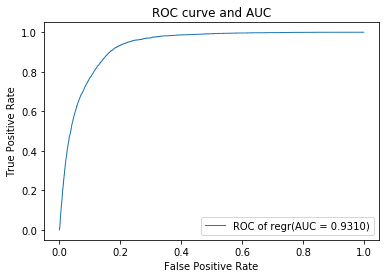

In [31]:
# ROC for test set
plt.gcf().clear()
for m,n in zip(models, modelsName):
    result = m.predict_proba(test_X)[:, 1]
    fpr, tpr, thresholds = roc_curve(test_Y, result)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1,label="ROC of "+ str(n) +"(AUC = %0.4f)" %roc_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve and AUC')
plt.legend(loc="lower right")
plt.show()